# UTILIZING NLP FOR VIDEO GAME DEVELOPMENT FROM ONLINE REVIEWS
**GROUP 8 – THE PYTHON PIONEERS**
* Members: CONAN LEUNG, DARA IRANZADI, JOSE ORTIZ
NICHOLAS FIUMETTO, ANDRE ABRAHIMIAN


# Steam Dataset Analysis Notebook

# Setup

## Libraries

In [11]:
!pip install textblob
!pip install vaderSentiment
!pip install wordcloud

In [12]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re
import urllib.parse

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup
from datetime import datetime, timezone
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob

In [13]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Helper Function Definitions

In [14]:
def convert_timestamp(timestamp):
    return datetime.fromtimestamp(timestamp, tz=timezone.utc).strftime("%H:%M, %B %d, %Y")

In [15]:
def set_day_range(year):
    start_date = datetime(year, 1, 1, tzinfo=timezone.utc)
    end_date = datetime.now(tz=timezone.utc)
    delta_days = (end_date - start_date).days
    return delta_days

In [16]:
# Data Cleaning Function
def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    words = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

In [17]:
# Filters Unconstructive Reviews
def is_constructive(review):
    words = review.split()
    # Filter based on length
    if len(words) < 5:
        return False
    # Filter based on repetitive phrases
    if len(set(words)) / len(words) < 0.5:
        return False
    # Add more conditions if needed
    return True

In [18]:
# Define a function to get the sentiment polarity and subjectivity
def analyze_sentiment(review):
    analysis = TextBlob(review)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

## Constants and Variable Declaration/Initialization

In [19]:
all_reviews = []
cursor = '*'
max_reviews = 1000  # Set the desired number of reviews to fetch
year = 2023  # Set the year
day_range = set_day_range(year)

app_id = '271590'  # Steam App ID for Grand Theft Auto V
base_url = f'https://store.steampowered.com/appreviews/{app_id}'
params = {
    "json": 1,
    "filter": "all",
    "language": "english",
    "day_range": day_range,
    "review_type": "all",
    "purchase_type": "all",
    "num_per_page": 100,
    "cursor": cursor  # Pagination cursor
}

# Import Data

In [20]:
while len(all_reviews) < max_reviews:
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Check if the request was successful
        data = response.json()  # Parse the JSON response

        # Check if 'reviews' is in the response
        if 'reviews' in data and len(data['reviews']) > 0:
            reviews = data['reviews']

            # Extract relevant details from reviews
            for review in reviews:
                review_details = {
                            "recommendationid": review["recommendationid"],
                            "author": review["author"]["steamid"],
                            "num_games_owned": review["author"]["num_games_owned"],
                            "num_reviews": review["author"]["num_reviews"],
                            # "playtime_forever": convert_timestamp(review["author"]["playtime_forever"]),
                            # "playtime_at_review": convert_timestamp(review["author"]["playtime_at_review"]),
                            "last_played": convert_timestamp(review["author"]["last_played"]),
                            "review": review["review"],
                            "timestamp_created": convert_timestamp(review["timestamp_created"]),
                            "voted_up": review["voted_up"],
                            "votes_up": review["votes_up"],
                            "votes_funny": review["votes_funny"],
                            "weighted_vote_score": review["weighted_vote_score"],
                            "comment_count": review["comment_count"]
                        }
                all_reviews.append(review_details)

            # Update the cursor for the next page
            cursor = data['cursor']

            # Print progress
            print(f"Fetched {len(all_reviews)} reviews so far...")

        else:
            # No more reviews to fetch
            break

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        break
    except ValueError as e:
        print(f"JSON decode failed: {e}")
        break

Fetched 100 reviews so far...
Fetched 200 reviews so far...
Fetched 300 reviews so far...
Fetched 400 reviews so far...
Fetched 500 reviews so far...
Fetched 600 reviews so far...
Fetched 700 reviews so far...
Fetched 800 reviews so far...
Fetched 900 reviews so far...
Fetched 1000 reviews so far...


In [21]:
# Create a DataFrame
df_reviews = pd.DataFrame(all_reviews)

## Export data to csv

Optional step

In [22]:
# Save the DataFrame to a CSV file
df_reviews.to_csv('gta_v_all_reviews.csv', index=False)

# Data Preprocessing

1. Data Cleaning
    - Convert the timestamp_created and last_played columns to datetime objects for easier analysis.
    - Removed HTML tags and special characters.
    - Converted text to lowercase, tokenized it, and removed stop words.
2. Handling Missing Values:
    - Removed rows where the cleaned review is empty.
3. Filtering Unconstructive Reviews:
    - Filtered out reviews that are too short or contain repetitive phrases.

In [23]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   recommendationid     1000 non-null   object
 1   author               1000 non-null   object
 2   num_games_owned      1000 non-null   int64 
 3   num_reviews          1000 non-null   int64 
 4   last_played          1000 non-null   object
 5   review               1000 non-null   object
 6   timestamp_created    1000 non-null   object
 7   voted_up             1000 non-null   bool  
 8   votes_up             1000 non-null   int64 
 9   votes_funny          1000 non-null   int64 
 10  weighted_vote_score  1000 non-null   object
 11  comment_count        1000 non-null   int64 
dtypes: bool(1), int64(5), object(6)
memory usage: 87.0+ KB


## Data Cleaning

In [24]:
# Convert the timestamp_created and last_played columns to datetime objects
df_reviews['timestamp_created'] = pd.to_datetime(df_reviews['timestamp_created'], format='%H:%M, %B %d, %Y')
df_reviews['last_played'] = pd.to_datetime(df_reviews['last_played'], format='%H:%M, %B %d, %Y')

In [25]:
# Apply data cleaning
df_reviews['cleaned_review'] = df_reviews['review'].apply(clean_text)

<ipython-input-16-a54a6e062f53>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


## Handle Missing Values

In [26]:
# Handle Missing Values
# Remove rows where 'cleaned_review' is empty after cleaning
df_reviews = df_reviews[df_reviews['cleaned_review'].str.strip() != '']

## Filtering Unconstructive Reviews

In [27]:
# Detrmine if a review is constructive
df_reviews = df_reviews[df_reviews['cleaned_review'].apply(is_constructive)]

In [28]:
df_reviews.head()

,recommendationid,author,num_games_owned,num_reviews,last_played,review,timestamp_created,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,cleaned_review
0,166853354,76561199105241405,44,21,2024-07-30 02:02:00,Very good game pls get rid of bikini lady in l...,2024-06-07 08:43:00,True,1163,1079,0.959909439086914063,0,good game pls get rid bikini lady loading scre...
1,144750846,76561198064681260,1123,14,2023-12-17 22:27:00,"Got into online and saw my IP address, ISP, an...",2023-08-21 21:52:00,True,285,156,0.946551501750946045,0,got online saw ip address isp location chat re...
2,159502375,76561199025610220,91,27,2024-02-20 12:20:00,GTA radio is better than actual radio.\nChange...,2024-02-28 23:41:00,True,581,95,0.9423256516456604,0,gta radio better actual radio change mind
4,163849493,76561199179723394,0,1,2024-07-24 23:14:00,"good game, Lester gets a lil freaky tho",2024-04-29 15:39:00,True,281,103,0.939632654190063477,6,good game lester gets lil freaky tho
5,155010209,76561198121870692,0,39,2022-10-17 15:22:00,10 years old in 2001 I got GTA 3 I begged my m...,2024-01-01 21:52:00,True,757,58,0.931322753429412842,3,years old got gta begged mom years old bought ...


# Sentiment Analysis

Perform text analysis on the review column to classify the sentiment and identify key themes. Create visualizations to represent the distribution of votes, the activity of reviewers, and trends over time.

In [29]:
# Apply the function to the 'cleaned_review' column
df_reviews[['sentiment_polarity', 'sentiment_subjectivity']] = df_reviews['cleaned_review'].apply(lambda x: pd.Series(analyze_sentiment(x)))

In [30]:
# Display the updated DataFrame
df_reviews.head()

,recommendationid,author,num_games_owned,num_reviews,last_played,review,timestamp_created,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,cleaned_review,sentiment_polarity,sentiment_subjectivity
0,166853354,76561199105241405,44,21,2024-07-30 02:02:00,Very good game pls get rid of bikini lady in l...,2024-06-07 08:43:00,True,1163,1079,0.959909439086914063,0,good game pls get rid bikini lady loading scre...,0.150000,0.5
1,144750846,76561198064681260,1123,14,2023-12-17 22:27:00,"Got into online and saw my IP address, ISP, an...",2023-08-21 21:52:00,True,285,156,0.946551501750946045,0,got online saw ip address isp location chat re...,0.200000,0.2
2,159502375,76561199025610220,91,27,2024-02-20 12:20:00,GTA radio is better than actual radio.\nChange...,2024-02-28 23:41:00,True,581,95,0.9423256516456604,0,gta radio better actual radio change mind,0.250000,0.3
4,163849493,76561199179723394,0,1,2024-07-24 23:14:00,"good game, Lester gets a lil freaky tho",2024-04-29 15:39:00,True,281,103,0.939632654190063477,6,good game lester gets lil freaky tho,0.150000,0.5
5,155010209,76561198121870692,0,39,2022-10-17 15:22:00,10 years old in 2001 I got GTA 3 I begged my m...,2024-01-01 21:52:00,True,757,58,0.931322753429412842,3,years old got gta begged mom years old bought ...,0.333333,0.2


## Sentiment Strengths

In [31]:
file_path = '/content/gta_v_all_reviews.csv'

words_to_analyze = [
    'online', 'story', 'friends', 'fun', 'gameplay', 'amazing', 'love', 'graphics', 'multiplayer',
    'crash', 'recommend', 'voice', 'characters', 'sound', 'music', 'loading', 'hate', 'soundtrack',
    'effects', 'community', 'performance', 'enjoyable', 'exciting', 'boring', 'frustrating',
    'terrible', 'buggy', 'disappointing', 'visuals', 'design', 'realistic', 'animation', 'controls',
    'mechanics', 'challenging', 'intuitive', 'plot', 'narrative', 'dialogue', 'coop', 'lag', 'fps'
]

analyzer = SentimentIntensityAnalyzer()

def process_reviews(file_path, words):
    df = pd.read_csv(file_path)

    if 'review' in df.columns:
        review_column = 'review'
    else:
        raise KeyError("No valid review column found in the dataset")

    df[review_column] = df[review_column].astype(str)
    df['compound'] = df[review_column].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    word_sentiment_totals = {word: 0 for word in words}
    word_counts = {word: 0 for word in words}

    for index, row in df.iterrows():
        review = row[review_column]
        sentiment = row['compound']
        for word in words:
            if word in review:
                word_sentiment_totals[word] += sentiment
                word_counts[word] += 1

    word_avg_sentiments = {word: (round(word_sentiment_totals[word] / word_counts[word], 3) if word_counts[word] > 0 else 0) for word in words}
    filtered_word_avg_sentiments = {word: avg_sentiment for word, avg_sentiment in word_avg_sentiments.items() if avg_sentiment != 0}
    print("\nAverage Sentiment Strengths of the Provided Words in Relation to the Reviews (Filtered and Rounded):")
    for word, avg_sentiment in filtered_word_avg_sentiments.items():
        print(f"{word}: {avg_sentiment}")

    return filtered_word_avg_sentiments

filtered_word_avg_sentiments = process_reviews(file_path, words_to_analyze)





Average Sentiment Strengths of the Provided Words in Relation to the Reviews (Filtered and Rounded):
online: 0.273
story: 0.917
friends: 0.816
fun: 0.721
gameplay: 0.982
amazing: 0.945
love: 0.862
graphics: 0.993
multiplayer: 0.997
crash: -0.348
recommend: 0.826
voice: 0.992
characters: 0.99
sound: 0.996
loading: -0.044
hate: -0.572
soundtrack: 0.996
effects: 0.996


In [32]:
def analyze_reviews(file_path, label):
    df = pd.read_csv(file_path)

    if 'review' in df.columns:
        review_column = 'review'
    else:
        raise KeyError("No valid review column found in the dataset")

    df[review_column] = df[review_column].astype(str)
    analyzer = SentimentIntensityAnalyzer()

    df['compound'] = df[review_column].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral')

    positive_reviews = df[df['sentiment'] == 'positive']
    negative_reviews = df[df['sentiment'] == 'negative']
    positive_strengths = positive_reviews['compound'].describe()
    negative_strengths = negative_reviews['compound'].describe()

    print(f"\nPositive Review Strengths ({label}):\n", positive_strengths)
    print(f"\nNegative Review Strengths ({label}):\n", negative_strengths)

analyze_reviews(file_path, 'GTA V Reviews')



Positive Review Strengths (GTA V Reviews):
 count    610.000000
mean       0.666933
std        0.263682
min        0.102700
25%        0.440400
50%        0.690800
75%        0.925800
max        0.996900
Name: compound, dtype: float64

Negative Review Strengths (GTA V Reviews):
 count    220.000000
mean      -0.532191
std        0.274729
min       -0.999400
25%       -0.796400
50%       -0.493900
75%       -0.296000
max       -0.099700
Name: compound, dtype: float64


In [33]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

def find_top_common_words(file_path):
    df = pd.read_csv(file_path)
    if 'review' in df.columns:
        review_column = 'review'
    else:
        raise KeyError("No valid review column found in the dataset")
    df[review_column] = df[review_column].astype(str)
    all_reviews_text = " ".join(df[review_column].dropna())
    vectorizer = CountVectorizer(stop_words='english')
    word_count = vectorizer.fit_transform([all_reviews_text])
    word_freq = Counter(dict(zip(vectorizer.get_feature_names_out(), word_count.toarray().sum(axis=0))))
    most_common_words = word_freq.most_common(20)
    print("\nTop 20 Most Common Words and Their Counts:")
    for word, count in most_common_words:
        print(f"{word}: {count}")
    return most_common_words

find_top_common_words(file_path)




Top 20 Most Common Words and Their Counts:
game: 950
gta: 470
just: 330
online: 320
rockstar: 280
good: 250
time: 230
like: 210
10: 200
cancer: 180
play: 180
story: 180
syndrome: 160
buy: 150
years: 150
review: 140
son: 140
pc: 130
friends: 120
people: 120


[('game', 950),
 ('gta', 470),
 ('just', 330),
 ('online', 320),
 ('rockstar', 280),
 ('good', 250),
 ('time', 230),
 ('like', 210),
 ('10', 200),
 ('cancer', 180),
 ('play', 180),
 ('story', 180),
 ('syndrome', 160),
 ('buy', 150),
 ('years', 150),
 ('review', 140),
 ('son', 140),
 ('pc', 130),
 ('friends', 120),
 ('people', 120)]

## Distribution of Sentiment Polarity

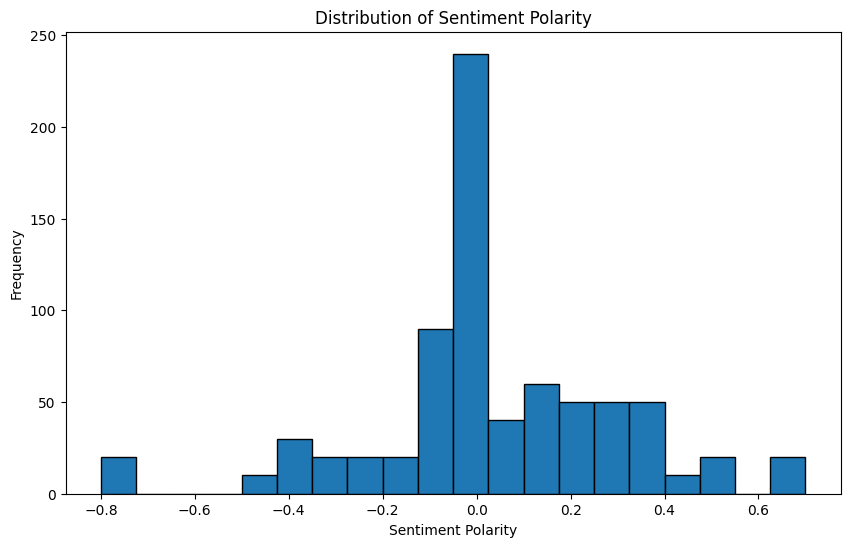

In [34]:
# Distribution of Sentiment Polarity
plt.figure(figsize=(10, 6))
plt.hist(df_reviews['sentiment_polarity'], bins=20, edgecolor='black')
plt.title('Distribution of Sentiment Polarity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

## Sentiment Polarity vs. Votes Up

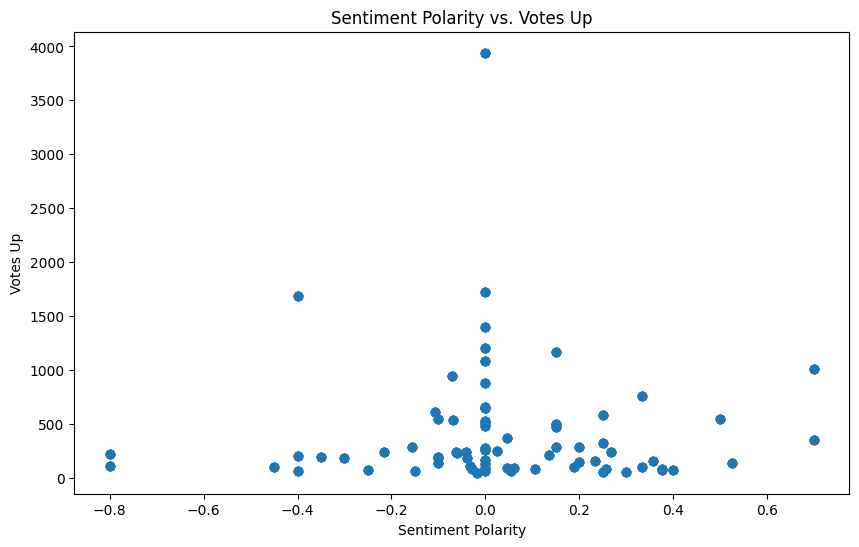

In [35]:
# Sentiment Polarity vs. Votes Up
plt.figure(figsize=(10, 6))
plt.scatter(df_reviews['sentiment_polarity'], df_reviews['votes_up'], alpha=0.5)
plt.title('Sentiment Polarity vs. Votes Up')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Votes Up')
plt.show()

## Number of Reviews Over Time

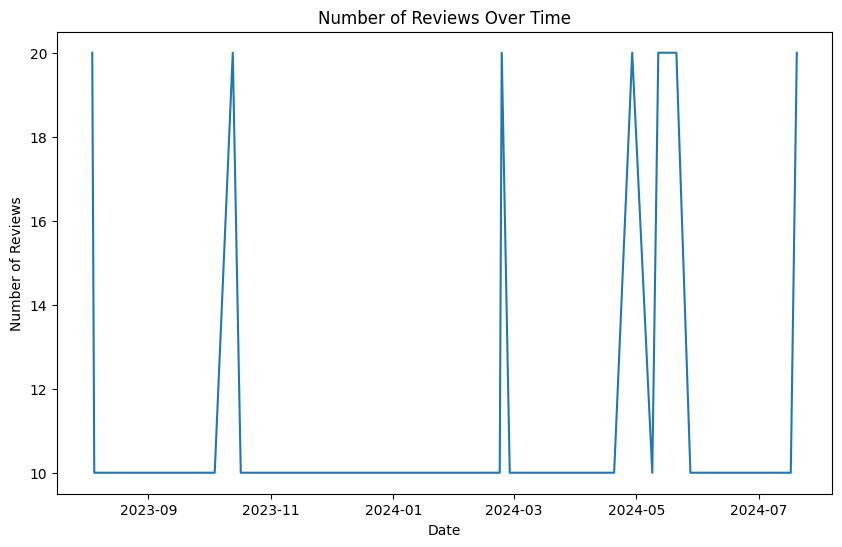

In [36]:
# Number of Reviews Over Time
df_reviews['date'] = df_reviews['timestamp_created'].dt.date
reviews_over_time = df_reviews.groupby('date').size()

plt.figure(figsize=(10, 6))
reviews_over_time.plot(kind='line')
plt.title('Number of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

## Average Sentiment Polarity Over Time

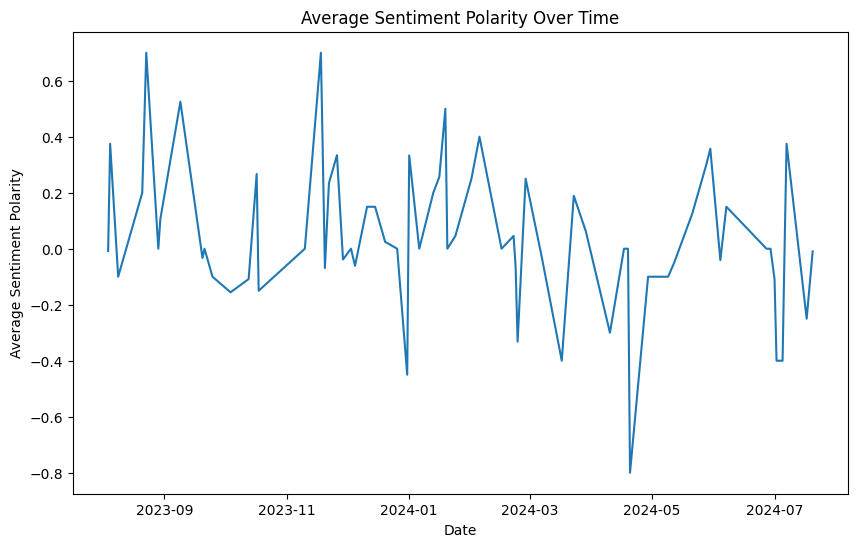

In [37]:
# Average Sentiment Polarity Over Time
average_sentiment_over_time = df_reviews.groupby('date')['sentiment_polarity'].mean()

plt.figure(figsize=(10, 6))
average_sentiment_over_time.plot(kind='line')
plt.title('Average Sentiment Polarity Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Polarity')
plt.show()

## Sentiment Analysis by Keyword

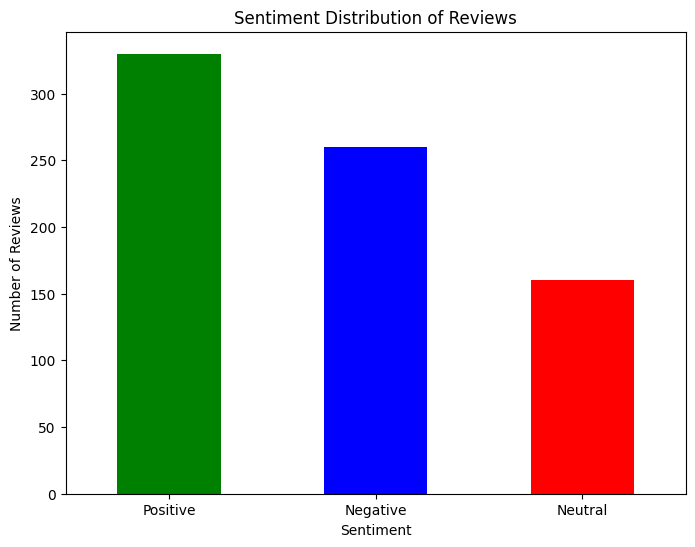

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from wordcloud import WordCloud
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import string


# Define stopwords
stop_words = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
    'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
    'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
    'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
    'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
    'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
    'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'
])

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# Apply preprocessing to the review column
df_reviews['processed_review'] = df_reviews['review'].apply(preprocess_text)

# Sentiment analysis function
def get_sentiment(review):
    analysis = TextBlob(review)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Apply sentiment analysis to the review column
df_reviews['sentiment'] = df_reviews['review'].apply(get_sentiment)

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
df_reviews['sentiment'].value_counts().plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Sentiment Distribution of Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()



In [39]:
# Keywords for analysis
keywords = [
    'online', 'story', 'friends', 'fun', 'gameplay', 'amazing', 'love', 'graphics', 'multiplayer',
    'crash', 'recommend', 'voice', 'characters', 'sound', 'music', 'loading', 'hate', 'soundtrack',
    'effects', 'community', 'performance', 'enjoyable', 'exciting', 'boring', 'frustrating',
    'terrible', 'buggy', 'disappointing', 'visuals', 'design', 'realistic', 'animation', 'controls',
    'mechanics', 'challenging', 'intuitive', 'plot', 'narrative', 'dialogue', 'coop', 'lag', 'fps'
]

# Dictionary to store sentiment counts for each keyword
keyword_sentiments = {keyword: {'Positive': 0, 'Neutral': 0, 'Negative': 0} for keyword in keywords}

# Analyze sentiment for each keyword
for keyword in keywords:
    keyword_reviews = df_reviews[df_reviews['review'].str.contains(keyword, case=False, na=False)]
    sentiment_counts = keyword_reviews['sentiment'].value_counts()
    for sentiment, count in sentiment_counts.items():
        keyword_sentiments[keyword][sentiment] = count

# Convert the dictionary to a DataFrame for better visualization
keyword_sentiments_df = pd.DataFrame(keyword_sentiments).T
keyword_sentiments_df = keyword_sentiments_df.sort_values(by=['Positive', 'Neutral', 'Negative'], ascending=False)

# Display the DataFrame
print(keyword_sentiments_df)



               Positive  Neutral  Negative
story               120        0        10
online              110        0        60
friends              50       40        30
fun                  50        0        40
love                 50        0        20
gameplay             50        0        10
graphics             50        0         0
sound                40        0         0
recommend            30       10         0
amazing              30        0         0
voice                20        0         0
characters           20        0         0
music                20        0         0
soundtrack           20        0         0
loading              10        0        20
multiplayer          10        0         0
effects              10        0         0
community            10        0         0
crash                 0        0        30
hate                  0        0         0
performance           0        0         0
enjoyable             0        0         0
exciting   

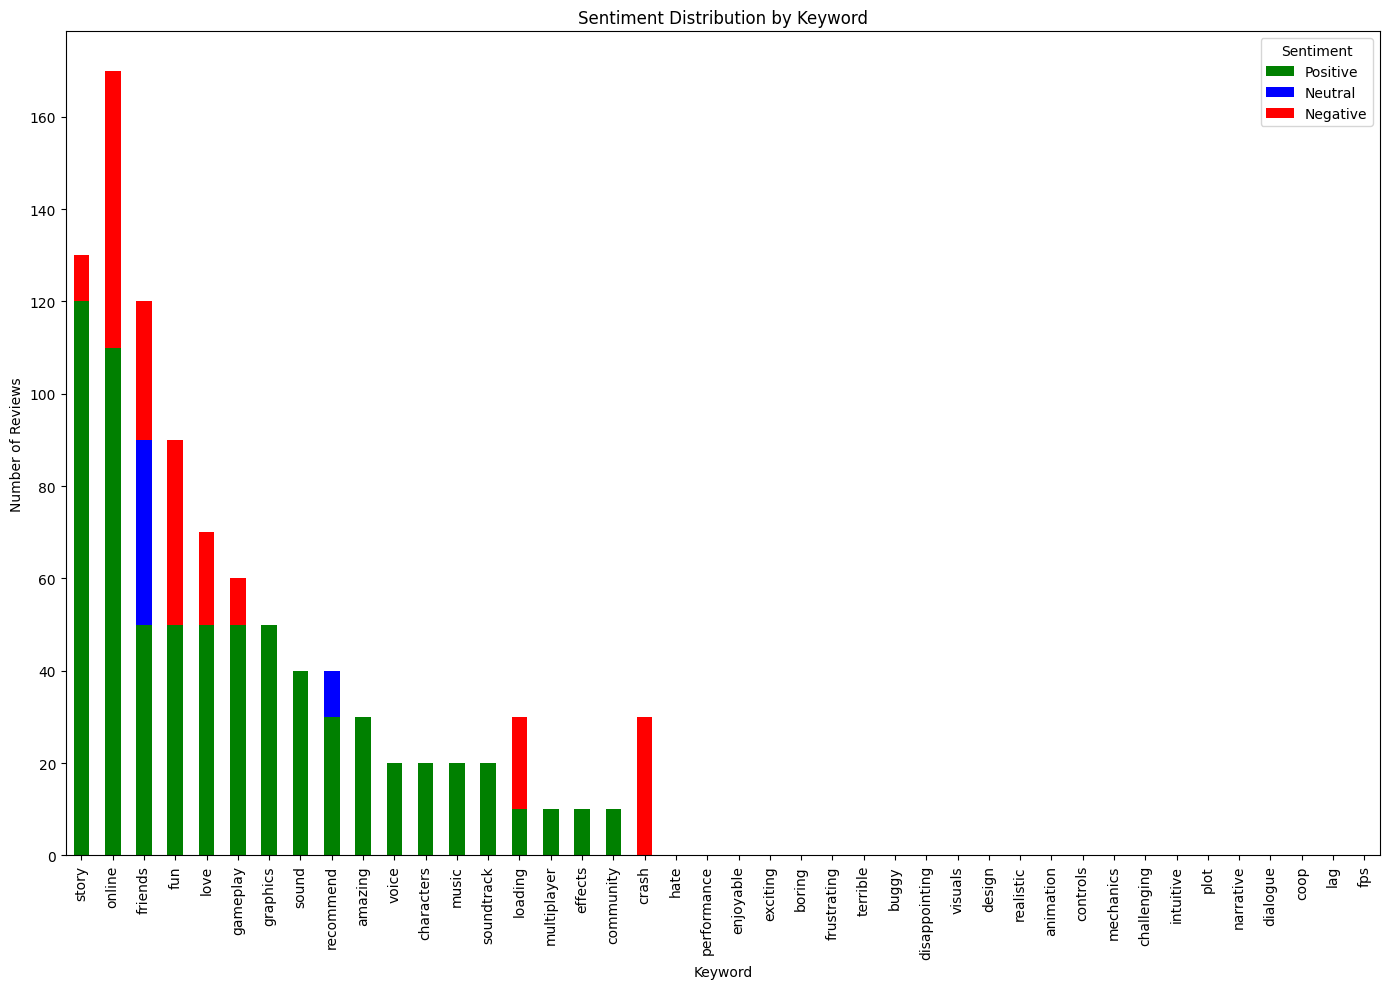

In [40]:
# Plot sentiment distribution for each keyword
fig, ax = plt.subplots(figsize=(14, 10))
keyword_sentiments_df.plot(kind='bar', stacked=True, ax=ax, color=['green', 'blue', 'red'])
ax.set_title('Sentiment Distribution by Keyword')
ax.set_xlabel('Keyword')
ax.set_ylabel('Number of Reviews')
ax.legend(title='Sentiment')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



## Sentiment Summary
1. Distribution of Sentiment Polarity:
    - The histogram shows that most reviews have a positive sentiment, as indicated by the concentration of sentiment polarity values on the positive side of the spectrum.
2. Sentiment Polarity vs. Votes Up:
    - The scatter plot indicates a weak correlation between sentiment polarity and the number of upvotes. Positive reviews generally receive more upvotes, but there is significant variability.
3. Number of Reviews Over Time:
    - The line plot shows the frequency of reviews over time. This can highlight periods of higher activity or interest in the game.
4. Average Sentiment Polarity Over Time:
    - The line plot indicates fluctuations in the average sentiment polarity over time. This can help identify periods where the sentiment was more positive or negative.
5. Sentiment Analysis By Keyword:
    - The bar chart shows the set of keywords chosen for significance for design or developer feedback and the sentiment distribution. This can show the the words are being used or communicated by reviewers to provide more context.


# N-Gram Analysis

## Generate N-Grams

**Define the N-gram Function**

In [41]:

# Define a function to generate n-grams
def generate_ngrams(text, n):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    ngrams = vectorizer.fit_transform(text)
    ngrams_df = pd.DataFrame(ngrams.toarray(), columns=vectorizer.get_feature_names_out())
    return ngrams_df.sum(axis=0).sort_values(ascending=False)


n = 2 # You can change this to 1 for unigrams, 3 for trigrams, etc.
df_reviews_cleaned = df_reviews['cleaned_review'].dropna() # Ensure there are no empty cells
top_ngrams = generate_ngrams(df_reviews_cleaned, n)
print(top_ngrams.head(20)) # Display the top 20 n-grams


gta online           130
theft auto            90
grand theft           80
give thumbs           60
gon na                50
gets likes            50
likes awards          50
awards buy            50
leave cat             50
pet give              50
rockstar launcher     40
cat friends           40
passes pet            40
good good             40
post review           40
years old             40
said post             40
one best              40
everybody passes      40
story mode            40
dtype: int64


**Generate Top Bigrams and Trigrams**

In [42]:

def generate_ngrams(text, n):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    ngrams = vectorizer.fit_transform(text)
    ngrams_df = pd.DataFrame(ngrams.toarray(), columns=vectorizer.get_feature_names_out())
    return ngrams_df.sum(axis=0).sort_values(ascending=False)


bigrams = generate_ngrams(df_reviews_cleaned, 2)
print("Top 20 Bigrams:")
print(bigrams.head(20))


trigrams = generate_ngrams(df_reviews_cleaned, 3)
print("Top 20 Trigrams:")
print(trigrams.head(20))


Top 20 Bigrams:
gta online           130
theft auto            90
grand theft           80
give thumbs           60
gon na                50
gets likes            50
likes awards          50
awards buy            50
leave cat             50
pet give              50
rockstar launcher     40
cat friends           40
passes pet            40
good good             40
post review           40
years old             40
said post             40
one best              40
everybody passes      40
story mode            40
dtype: int64
Top 20 Trigrams:
grand theft auto         80
likes awards buy         50
gets likes awards        50
pet give thumbs          50
im gon na                40
everybody passes pet     40
leave cat everybody      40
gon na leave             40
said post review         40
give thumbs awards       40
cat everybody passes     40
passes pet give          40
cs said post             30
touch click like         30
got cat friends          30
cat friends passing      30
passin

## Building a Sentiment Analyzer per N-Gram

In [43]:

def sentiment_by_ngram(df, ngram):
    reviews_with_ngram = df[df['cleaned_review'].str.contains(ngram)]
    sentiment_avg = reviews_with_ngram['sentiment_polarity'].mean()
    return sentiment_avg


ngram_to_analyze = 'good game' # Replace with any n-gram of interest
average_sentiment = sentiment_by_ngram(df_reviews, ngram_to_analyze)
print(f"Average sentiment for reviews containing '{ngram_to_analyze}': {average_sentiment}")


Average sentiment for reviews containing 'good game': 0.1282638888888889


## N-Gram Word Clouds

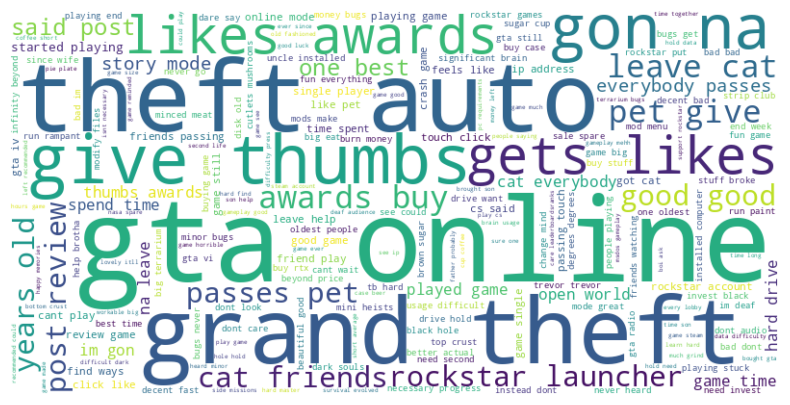

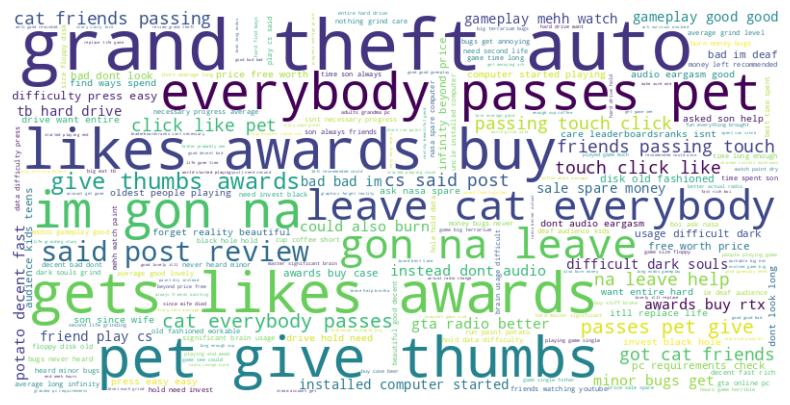

In [44]:
from wordcloud import WordCloud

def generate_wordcloud(ngrams):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(ngrams)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


generate_wordcloud(bigrams)

generate_wordcloud(trigrams)


## Top Bigrams and Trigrams Charts

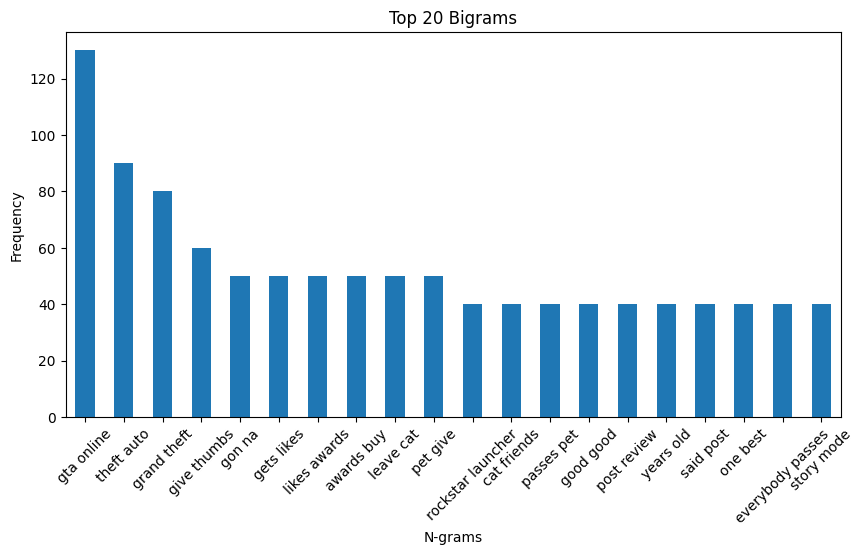

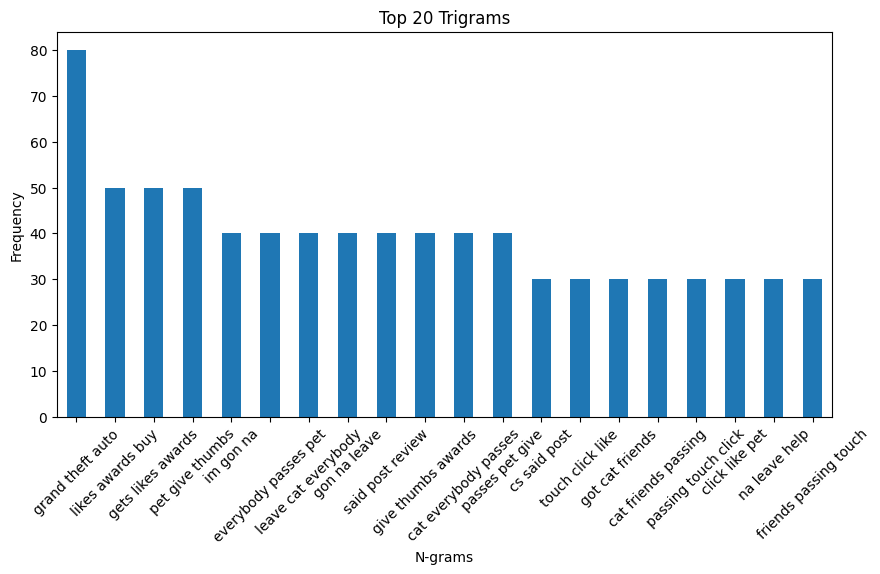

In [45]:
import matplotlib.pyplot as plt


def plot_ngrams(ngrams, title):
    ngrams.head(20).plot(kind='bar', figsize=(10, 5))
    plt.title(title)
    plt.xlabel('N-grams')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()


plot_ngrams(bigrams, 'Top 20 Bigrams')


plot_ngrams(trigrams, 'Top 20 Trigrams')


## Filtered by Constructive and Non-Constructive Reviews

In [46]:
def is_constructive(review):
    return len(review.split()) > 5  # Example: a review is constructive if it has more than 5 words

# Re-create the 'is_constructive' column
df_reviews['is_constructive'] = df_reviews['cleaned_review'].apply(is_constructive)

# Verify the column update
print(df_reviews[['cleaned_review', 'is_constructive']].head(10))

                                       cleaned_review  is_constructive
0   good game pls get rid bikini lady loading scre...             True
1   got online saw ip address isp location chat re...             True
2           gta radio better actual radio change mind             True
4                good game lester gets lil freaky tho             True
5   years old got gta begged mom years old bought ...             True
6   b gameplay breakdown b shooting heists driving...             True
7   loved part michael came said thefting time the...             True
8   nobody read review eat tablespoon hotsauce eve...             True
9   played game lazy suicidal sad didnt much aside...             True
11          gta radio better actual radio change mind             True


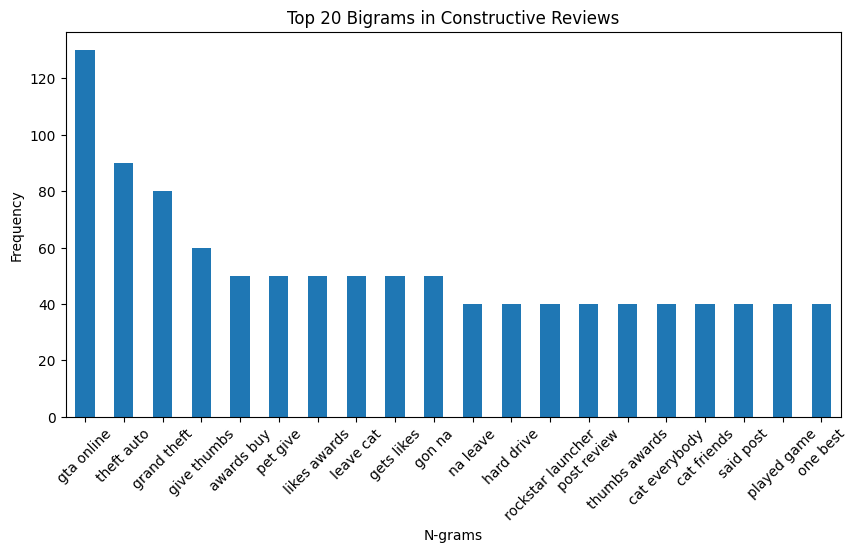

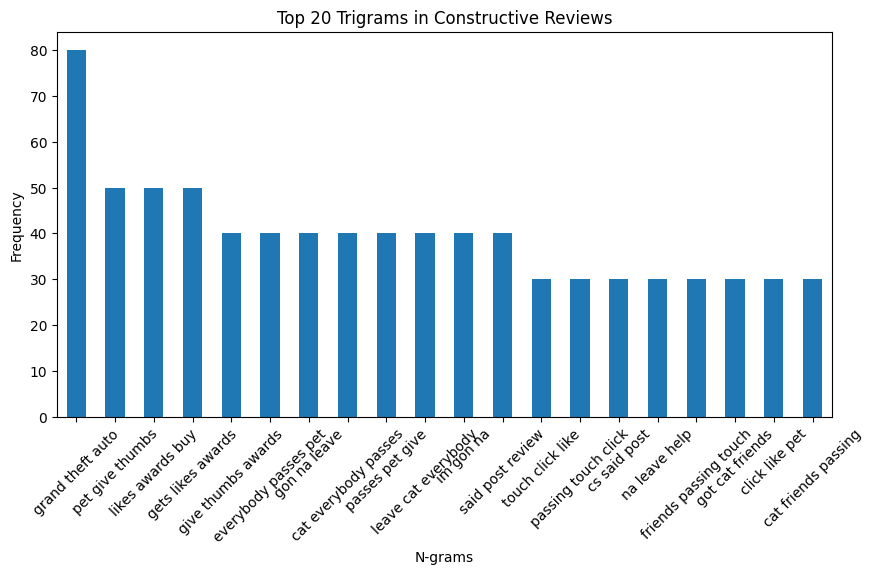

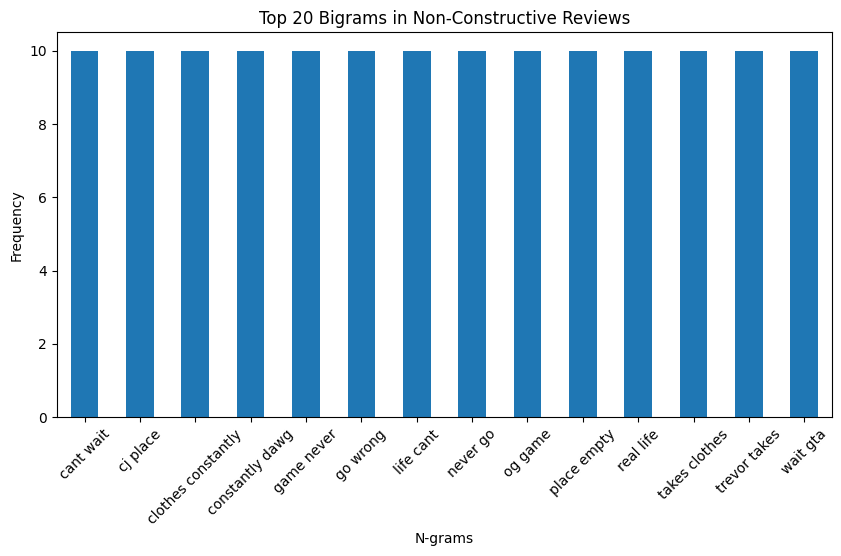

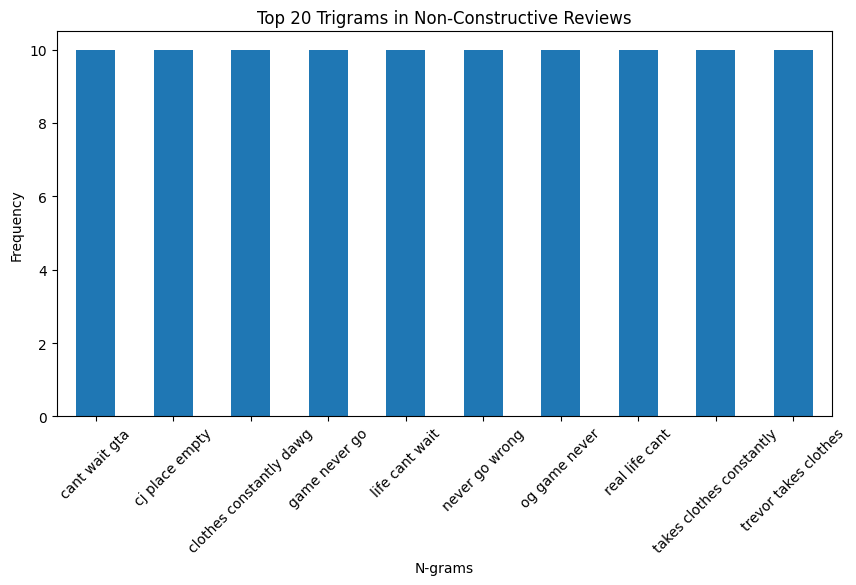

In [47]:
# Filter constructive and non-constructive reviews
constructive_reviews = df_reviews[df_reviews['is_constructive'] == True]['cleaned_review']
non_constructive_reviews = df_reviews[df_reviews['is_constructive'] == False]['cleaned_review']

# Generate and plot n-grams for constructive reviews
constructive_bigrams = generate_ngrams(constructive_reviews, 2)
plot_ngrams(constructive_bigrams, 'Top 20 Bigrams in Constructive Reviews')

constructive_trigrams = generate_ngrams(constructive_reviews, 3)
plot_ngrams(constructive_trigrams, 'Top 20 Trigrams in Constructive Reviews')

# Generate and plot n-grams for non-constructive reviews
non_constructive_bigrams = generate_ngrams(non_constructive_reviews, 2)
plot_ngrams(non_constructive_bigrams, 'Top 20 Bigrams in Non-Constructive Reviews')

non_constructive_trigrams = generate_ngrams(non_constructive_reviews, 3)
plot_ngrams(non_constructive_trigrams, 'Top 20 Trigrams in Non-Constructive Reviews')



## N-Grams Summary

**Overview**

The analysis focused on identifying and visualizing the most common bigrams and trigrams in both constructive and non-constructive reviews for the game "Grand Theft Auto V".



**Top Bigrams:**

Common phrases include "cant wait", "cj place", "clothes constantly", "game never", and "go wrong". These phrases often reflect immediate reactions or simple, repetitive comments without substantial details or constructive feedback.


**Top Trigrams:**

 Frequent phrases are "cant wait gta", "cj place empty", "clothes constantly dawg", and "game never go". These trigrams similarly exhibit a lack of detailed feedback, focusing more on brief sentiments or observations.
Bigrams and Trigrams in Constructive Reviews

**Top Bigrams:**

 Notable bigrams include "gta online", "grand theft", "give thumbs", "cat friends", and "pet give". These phrases suggest a focus on specific features or experiences in the game, providing more detailed feedback.
Top Trigrams: Prominent trigrams are "grand theft auto", "pet give thumbs", "likes awards buy", "gets likes awards", and "touch click like". These reflect detailed interactions with the game, such as in-game features and mechanics, indicating a more thorough review process.
Word Cloud Analysis:

**Sentiment Analysis:**

The average sentiment for reviews containing the phrase "good game" was calculated to be approximately 0.1283, indicating a generally positive sentiment. This suggests that reviews using this phrase tend to lean towards a positive perception of the game.



**Constructive Feedback:**

Reviews classified as constructive tend to include detailed and specific feedback about game features, mechanics, and personal experiences. This information is valuable for developers seeking to understand player preferences and areas for improvement.


**Non contructive feedback:**

Reviews deemed non-constructive often contain brief and repetitive comments that lack actionable insights. These reviews may still reflect overall sentiment but are less useful for detailed feedback.




# Topic Modeling

## Creating and Training the LDA Model for All Reviews

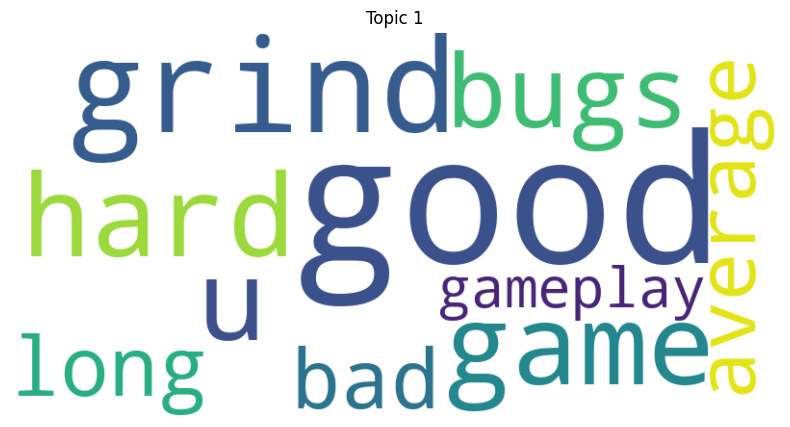

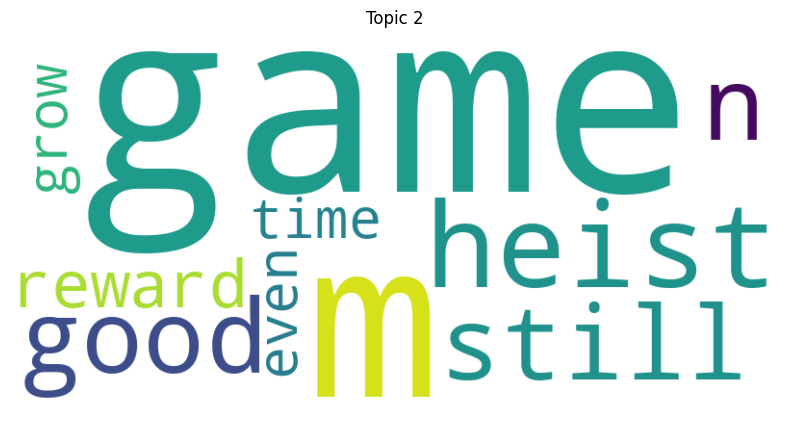

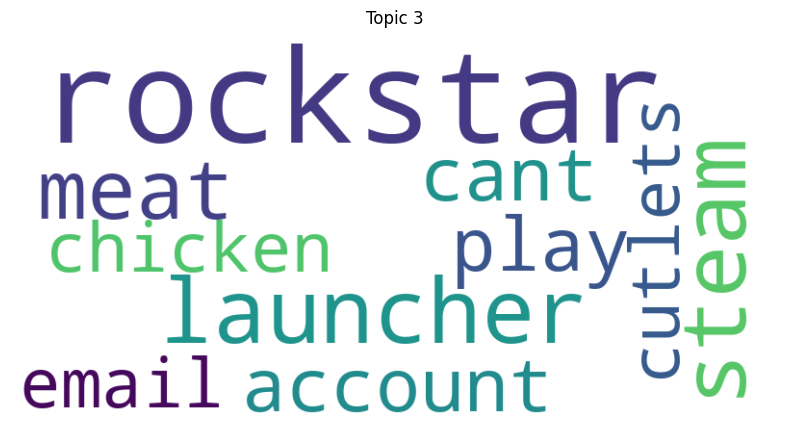

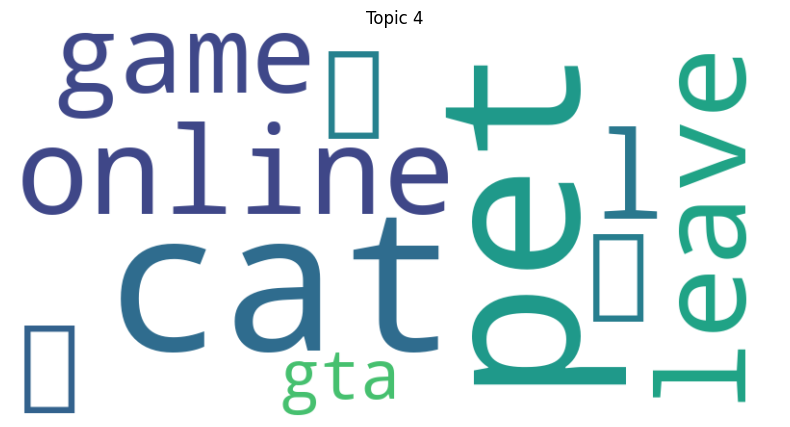

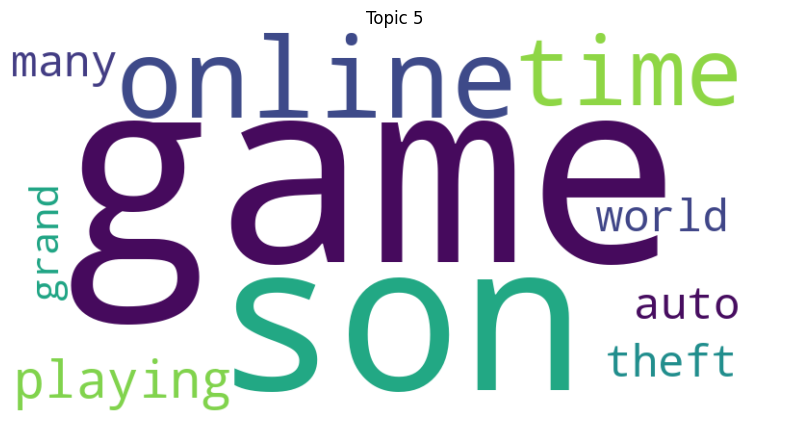

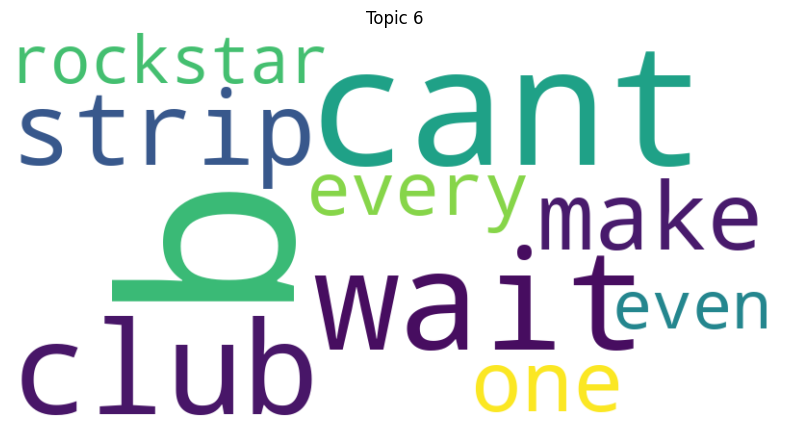

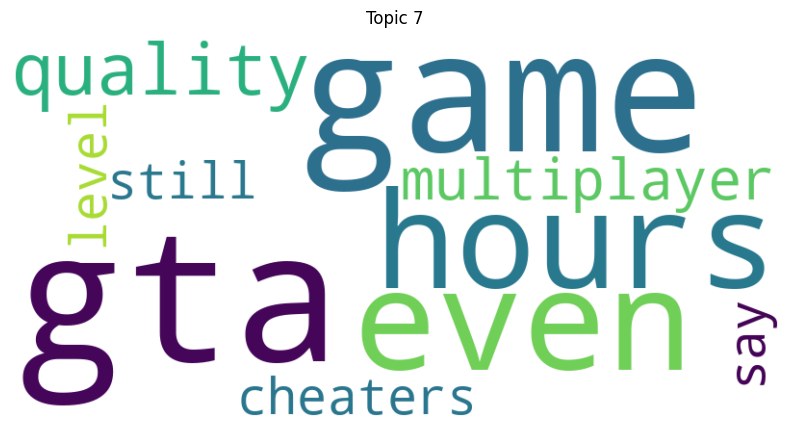

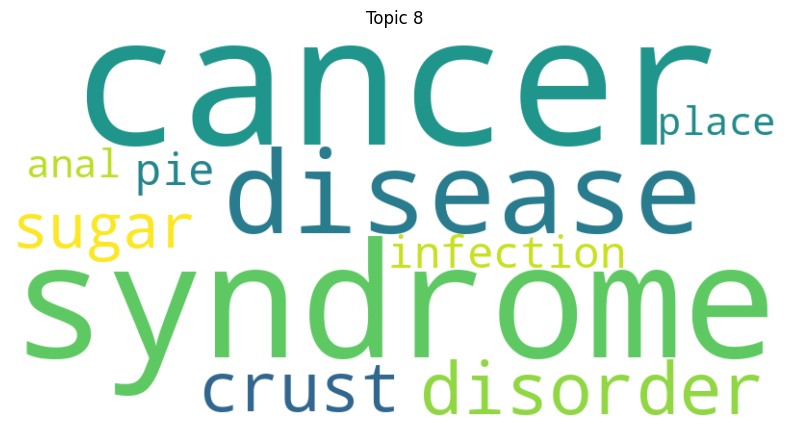

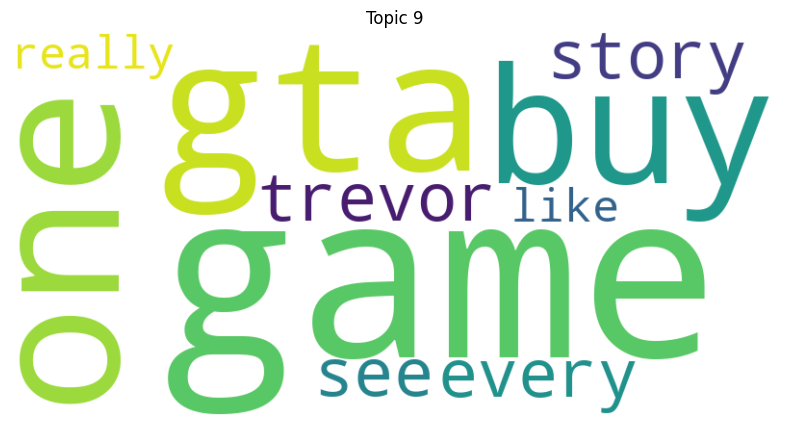

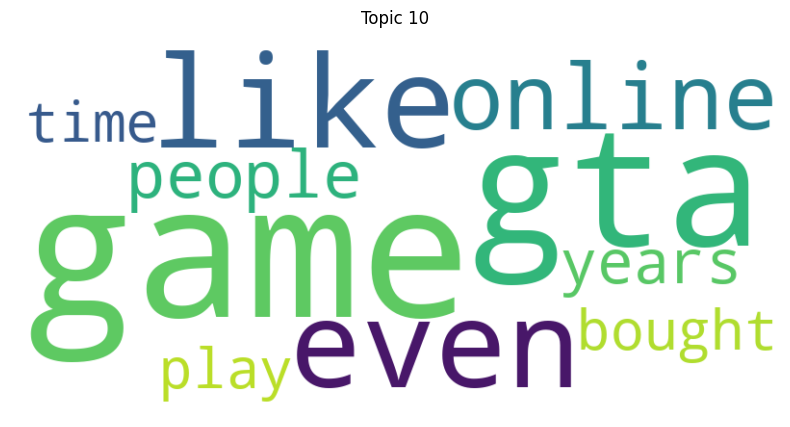

In [48]:
# Create a dictionary and corpus for all reviews
dictionary = Dictionary(df_reviews['processed_review'])
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in df_reviews['processed_review']]

# Train the LDA model
num_topics = 10
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42)

# Plot word clouds for all topics
def plot_word_cloud(lda_model, topic_num, num_words=10):
    words = dict(lda_model.show_topic(topic_num, num_words))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_num + 1}')
    plt.show()

for i in range(num_topics):
    plot_word_cloud(lda_model, i, num_words=10)


**Seek Ideal Number of Topics from Coherence Scores**

In [ ]:
from gensim.models import CoherenceModel, LdaModel
from gensim.corpora import Dictionary

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

df_reviews['processed_review'] = df_reviews['review'].apply(preprocess_text)

# Create dictionary and corpus for LDA
dictionary = Dictionary(df_reviews['processed_review'])
corpus = [dictionary.doc2bow(text) for text in df_reviews['processed_review']]

# Function to compute coherence values for different numbers of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Compute coherence values
start, limit, step = 2, 40, 2
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=df_reviews['processed_review'], start=start, limit=limit, step=step)

# Plot coherence score
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Find the optimal number of topics
optimal_num_topics = x[coherence_values.index(max(coherence_values))]
print(f"Optimal number of topics: {optimal_num_topics}")

# Train the LDA model with the optimal number of topics
optimal_lda_model = LdaModel(corpus=corpus, num_topics=optimal_num_topics, id2word=dictionary, passes=15, random_state=42)

# Compute and print coherence for the optimal model
optimal_coherencemodel = CoherenceModel(model=optimal_lda_model, texts=df_reviews['processed_review'], dictionary=dictionary, coherence='c_v')
print(f'Optimal Model Coherence Score: {optimal_coherencemodel.get_coherence()}')

Results Indicate Model Needs Refining, Reducing Topics to 7

In [ ]:
# Exclude noisy topics and re-run the LDA with fewer topics (7 topics)
num_topics_refined = 7

# Train the LDA model again with fewer topics
lda_model_refined = LdaModel(corpus, num_topics=num_topics_refined, id2word=dictionary, passes=15, random_state=42)

# Get the refined topics
refined_topics = lda_model_refined.print_topics(num_words=10)

# Display the refined topics
refined_topics

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to plot word cloud for a given topic
def plot_word_cloud(lda_model, topic_num, num_words=10):
    words = dict(lda_model.show_topic(topic_num, num_words))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_num + 1}')
    plt.show()

# Plot word clouds for all refined topics
for i in range(num_topics_refined):
    plot_word_cloud(lda_model_refined, i, num_words=10)

In [ ]:
# Extract top words for each topic
top_words_per_topic = []
for i in range(num_topics_refined):
    top_words = lda_model_refined.show_topic(i, topn=10)
    top_words_per_topic.append(top_words)

# Convert to a DataFrame for better readability
top_words_df = pd.DataFrame(top_words_per_topic)
top_words_df.columns = [f'Word {i+1}' for i in range(10)]
top_words_df.index = [f'Topic {i+1}' for i in range(num_topics_refined)]



top_words_df

**Topic 1**

Top Words: good, game, grind, long, story, bad, bugs, hard, average, gameplay

Interpretation: This topic seems to focus on the overall quality of the game, including both positive aspects (good, story, gameplay) and negative aspects (grind, long, bad, bugs, hard, average). It suggests a mixed sentiment towards the game's quality and play experience.

**Topic 2**

Top Words: game, like, even, time, people, online, crust, gta, get, pie

Interpretation: This topic covers general comments about the game, time spent playing, and interactions with other players (people, online). There are some unrelated culinary terms (crust, pie), indicating potential noise in this topic. The keyword "gta" suggests the game in question, but the presence of unrelated terms requires further filtering.

**Topic 3**

Top Words: game, online, auto, theft, grand, review, gta, buy, said, im

Interpretation: This topic is centered around Grand Theft Auto (GTA), specifically the online mode and reviews about it. Keywords like "auto," "theft," and "grand" are directly related to GTA. It also includes
feedback from reviews (review, buy, said).

**Topic 4**

Top Words: cancer, syndrome, disease, ヽ, l, フ, ﾉ, give, disorder, cat

Interpretation: This topic contains unrelated medical terms (cancer, syndrome, disease, disorder) and some non-alphabetic characters (ヽ, l, フ, ﾉ). These terms suggest noise and unrelated content that should be filtered out for a more accurate topic.

**Topic 5**

Top Words: game, gta, online, still, radio, cheaters, play, r, better, literally

Interpretation: This topic discusses aspects of GTA Online, including issues with cheaters, the game's radio, and comparisons to other elements (better, literally). The word "still" might indicate ongoing issues or persistent gameplay elements.

**Topic 6**

Top Words: game, rockstar, son, gta, play, launcher, time, steam, playing, online

Interpretation: This topic focuses on the game's publisher (Rockstar), playing experience (son, play, time, playing, online), and technical aspects like the launcher and Steam platform. It indicates feedback related to both gameplay and technical issues.

**Topic 7**

Top Words: gta, game, one, online, much, like, story, v, trevor, really

Interpretation: This topic includes feedback on GTA, including the story, characters (Trevor), and general sentiments (much, like, really). It also touches on the online mode and overall gameplay experience.

Summary and Key Topics:

* Topic 1: Mixed feedback on game quality and
experience, including positive aspects (good, story) and negative aspects (grind, bugs, hard).
* Topic 2: General comments about the game and online interactions, with some noise (crust, pie).
* Topic 3: Focus on GTA Online and reviews, mentioning the game's title and purchase feedback.
* Topic 4: Contains noise and unrelated terms, suggesting the need for further filtering.
* Topic 5: Feedback on GTA Online, issues with cheaters, and gameplay elements like the radio.
* Topic 6: Focus on gameplay experience and technical aspects related to Rockstar, the launcher, and Steam.
* Topic 7: Feedback on GTA's story, characters, and overall gameplay experience.




## LDA Topic Extraction for Positive/Negative Subsets

### Filtered by positive reviews

In [ ]:
# Filter positive reviews
positive_reviews_df = df_reviews[df_reviews['sentiment'] == 'Positive']

# Create a dictionary and corpus for positive reviews
positive_dictionary = Dictionary(positive_reviews_df['processed_review'])
positive_dictionary.filter_extremes(no_below=5, no_above=0.5)
positive_corpus = [positive_dictionary.doc2bow(text) for text in positive_reviews_df['processed_review']]

# Train the LDA model for positive reviews
num_topics_positive = 7
positive_lda_model = LdaModel(positive_corpus, num_topics=num_topics_positive, id2word=positive_dictionary, passes=15, random_state=42)

# Extract the topics
positive_topics = positive_lda_model.print_topics(num_words=10)

# Display the topics
for idx, topic in positive_topics:
    print(f"Topic {idx}: {topic}")

# Plot word clouds for all positive topics
def plot_word_cloud(lda_model, topic_num, num_words=10):
    words = dict(lda_model.show_topic(topic_num, num_words))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_num + 1}')
    plt.show()

for i in range(num_topics_positive):
    plot_word_cloud(positive_lda_model, i, num_words=10)


#### Positive Topic Interpretation

**Topic 0:** Noise and Unrelated Content

Top Words: crust, pie, rockstar, pastry, degrees, sugar, place, launcher, cup, top

Key Feedback: This topic seems to contain a lot of noise and unrelated culinary terms.

Improvements:
Filter Out Noise: Implement more advanced text preprocessing to remove irrelevant content.

**Topic 1:**  Positive GTA Online Experience
Top Words: gta, online, good, like, heists, got, friends, never, life, one

Key Feedback: Positive feedback on GTA Online, highlighting heists, playing with friends, and the overall good experience.

Improvements:
Enhance Online Features: Continue improving GTA Online features, focusing on heists and social interactions.

**Topic 2**: Mixed Gameplay Experience

Top Words: good, grind, long, bugs, bad, hard, average, time, life, story

Key Feedback: Mixed feedback with positive notes on the game being good, but also mentions of grind, bugs, and difficulty.

Improvements:
Reduce Grinding: Make the game progress less grind-heavy.

Fix Bugs: Continue focusing on bug fixes.

Balance Difficulty: Ensure the game is challenging but fair.

**Topic 3**: Story and Rockstar

Top Words: rockstar, story, years, still, even, gta, like, time, much, female

Key Feedback: Positive feedback on the story and Rockstar, with a mention of female characters.

Improvements:
Enhance Storytelling: Invest in deeper, more engaging storylines.

Diverse Characters: Develop more diverse and well-rounded characters, including female characters.

**Topic 4**: GTA Experience

Top Words: gta, online, auto, v, theft, radio, world, even, bought, grand

Key Feedback: General positive feedback on GTA, including the online mode, radio, and world-building.

Improvements:
Enhance World-Building: Continue developing the in-game world and its features, such as the radio.

Improve Online Experience: Focus on the online mode and its various elements.

**Topic 5**: Quality and Content

Top Words: gta, multiplayer, quality, good, level, content, everything, hours, missions, story

Key Feedback: Positive feedback on the quality, multiplayer mode, content, and missions.

Improvements:
Expand Content: Add more high-quality content and missions.

Enhance Multiplayer: Continue improving the multiplayer experience.

**Topic 6**: Characters and Series

Top Words: gta, one, trevor, something, games, like, really, every, series, story

Key Feedback: Positive feedback on characters (e.g., Trevor) and the GTA series.

Improvements:
Character Development: Continue developing engaging characters like Trevor.

Series Continuation: Maintain the high standards of the GTA series.



#### Summary of Key Topics for Improvements From Positives

* Filter Out Noise:

Improve text preprocessing to remove irrelevant content (Topic 0). Will work on this as the project progresses.

* Enhance Online Features:

Focus on improving GTA Online, especially heists and social interactions (Topic 1).

* Gameplay Experience:

Reduce grinding, fix bugs, and balance difficulty (Topic 2).

* Story and Characters:

Invest in deeper storytelling and develop diverse characters, including more female characters (Topic 3).

* World-Building Features and Online Experience:

Enhance in-game world features like the radio and continue improving the online mode (Topic 4).

* Content and Missions:

Expand high-quality content and missions, and improve multiplayer (Topic 5).

* Character Development and Series Continuation:

Focus on character development and maintaining the high standards of the GTA series (Topic 6).

### Filtered by Negative Reviews

In [ ]:
# Filter negative reviews
negative_reviews_df = df_reviews[df_reviews['sentiment'] == 'Negative']

# Create a dictionary and corpus for negative reviews
negative_dictionary = Dictionary(negative_reviews_df['processed_review'])
negative_dictionary.filter_extremes(no_below=5, no_above=0.5)
negative_corpus = [negative_dictionary.doc2bow(text) for text in negative_reviews_df['processed_review']]

# Train the LDA model for negative reviews
num_topics_negative = 7
negative_lda_model = LdaModel(negative_corpus, num_topics=num_topics_negative, id2word=negative_dictionary, passes=15, random_state=42)

# Extract the topics
negative_topics = negative_lda_model.print_topics(num_words=10)

# Display the topics
for idx, topic in negative_topics:
    print(f"Topic {idx}: {topic}")

# Plot word clouds for all negative topics
def plot_word_cloud(lda_model, topic_num, num_words=10):
    words = dict(lda_model.show_topic(topic_num, num_words))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_num + 1}')
    plt.show()

for i in range(num_topics_negative):
    plot_word_cloud(negative_lda_model, i, num_words=10)


#### Negative Topic Interpretation


**Topic 0**: Cheating and Online Issues

Top Words: m, online, cheating, cheaters, n, r, u, b, portion, mode

Key Feedback: This topic focuses on issues with cheating in online modes, including cheaters and various symbols that may represent specific players or codes.

Improvements:

Implement Anti-Cheat Measures: Enhance anti-cheating mechanisms to reduce cheating in online modes.

Monitor and Address Cheaters: Increase monitoring of player behavior and implement stricter consequences for cheaters.

**Topic 1**: Modders and Security Concerns

Top Words: online, people, pc, modders, like, malware, rockstar, whenever, playing, im

Key Feedback: This topic highlights concerns about modders, malware, and security issues on PC, as well as general dissatisfaction with the online experience.

Improvements:

Strengthen Security: Implement measures to prevent malware and modder interference.

Enhance Online Experience: Improve the stability and security of online gameplay.

**Topic 2**: Persistent Online Play Issues

Top Words: play, gta, online, still, playing, always, session, one, people, help

Key Feedback: Ongoing issues with online play, including session stability, and seeking help from other players.

Improvements:

Improve Online Stability: Enhance the stability of online sessions to reduce disconnections and other issues.

Provide Better Support: Offer better in-game support for players experiencing issues.

**Topic 3**: Noise and Irrelevant Content

Top Words: cancer, syndrome, disease, disorder, infection, anal, bowel, kidney, disorders, brain

Key Feedback: This topic contains unrelated medical terms, indicating noise and irrelevant content.

Improvements:

Filter Out Noise: Improve text preprocessing to remove irrelevant content.

**Topic 4**: Gameplay and Personal Stories

Top Words: son, time, playing, play, father, since, started, spend, launcher, account

Key Feedback: Personal stories about playing the game, often with family members, and some mentions of technical issues with the launcher and accounts.

Improvements:

Enhance Family Play Features: Introduce features that cater to family play and shared gaming experiences.

Fix Launcher Issues: Address technical problems related to the game launcher and account management.

**Topic 5**: Noise and Minor Issues

Top Words: online, cheaters, m, r, report, still, crash, n, literally, even

Key Feedback: This topic appears to contain noise and minor issues related to online play and cheating.

Improvements:

Filter Out Noise: Further improve text preprocessing to focus on more relevant feedback.

**Topic 6**: Heists and Gameplay Frustrations

Top Words: online, heist, rockstar, play, last, getting, crazy, today, back, still

Key Feedback: Frustrations with heists in online play and general gameplay issues.

Improvements:

Improve Heist Features: Address frustrations with heists and make them more enjoyable.

Enhance Gameplay Stability: Focus on resolving gameplay issues that lead to player frustration.

## LDA Modeling Summary

#### Summary of Key Topics for Improvement

### Mixed Feedback (Positive and Negative Reviews Combined)
1. **Game Quality and Experience:**
   - Reduce grinding, fix bugs, and balance difficulty.
   - Improve overall game stability and play experience.

2. **Online Experience:**
   - Enhance online features, especially heists and social interactions.
   - Improve the stability and security of online gameplay.

3. **Story and Characters:**
   - Invest in deeper storytelling and develop diverse, engaging characters.
   - Focus on character development and maintaining the high standards of the GTA series.

4. **World-Building and Content:**
   - Continue developing the in-game world and its features.
   - Expand high-quality content and missions.

5. **Technical Performance:**
   - Optimize game performance, reduce loading times, and ensure smooth gameplay across all platforms.

### Positive Reviews
1. **Enhance Online Features:**
   - Continue improving GTA Online features, focusing on heists and social interactions.

2. **Gameplay Experience:**
   - Maintain or enhance elements contributing to player enjoyment.
   - Reduce grinding, fix bugs, and balance difficulty.

3. **Story and Characters:**
   - Invest in deeper, more engaging storylines.
   - Develop more diverse and well-rounded characters, including female characters.

4. **World-Building and Online Experience:**
   - Continue developing the in-game world and its features, such as the radio.
   - Focus on the online mode and its various elements.

5. **Content and Missions:**
   - Add more high-quality content and missions.
   - Continue improving the multiplayer experience.

6. **Technical Performance:**
   - Continue optimizing game performance and reducing loading times.

7. **Audio and Music:**
   - Enhance audio quality and ensure immersive sound design.
   - Add more varied and engaging music tracks.

### Negative Reviews
1. **Cheating and Online Issues:**
   - Implement stronger anti-cheat measures.
   - Increase monitoring of player behavior and implement stricter consequences for cheaters.

2. **Modders and Security Concerns:**
   - Strengthen security to prevent malware and modder interference.
   - Improve the stability and security of online gameplay.

3. **Persistent Online Play Issues:**
   - Enhance the stability of online sessions and provide better in-game support for players experiencing issues.

4. **Noise and Irrelevant Content:**
   - Improve text preprocessing to filter out noise and irrelevant content.

5. **Gameplay and Personal Stories:**
   - Introduce features that cater to family play and shared gaming experiences.
   - Address technical problems related to the game launcher and account management.

6. **Heists and Gameplay Frustrations:**
   - Address frustrations with heists and general gameplay issues to make the experience more enjoyable.
   - Focus on resolving gameplay issues that lead to player frustration.

### Overlapping Actions for Developers/Designers
Based on the feedback from mixed, positive, and negative reviews, the following overlapping actions can be addressed to improve the overall gaming experience:

1. **Enhance Online Features and Security:**
   - Improve online connectivity and multiplayer features.
   - Implement stronger anti-cheat measures and enhance security to prevent modder interference and malware.

2. **Improve Gameplay Experience:**
   - Reduce grinding and balance game difficulty.
   - Focus on bug fixes and optimizing game performance for a smoother experience.

3. **Develop Engaging Storylines and Characters:**
   - Invest in deeper storytelling and character development.
   - Ensure diverse and well-rounded character representations.

4. **Expand and Enhance Content:**
   - Continue developing high-quality content and missions.
   - Enhance world-building elements and in-game features like the radio.

5. **Optimize Technical Performance:**
   - Address technical issues related to the game launcher and account management.
   - Ensure smooth gameplay with reduced loading times and optimized performance across all platforms.

6. **Improve Audio and Music:**
   - Enhance audio quality and ensure immersive sound design.
   - Add more varied and engaging music tracks.

## Additional Models for Topic Modeling

### NMF Implementation for Comparison to LDA

In [ ]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess the text data and create a TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(negative_reviews_df['review'])

# Apply NMF
num_topics = 7
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_topics = nmf_model.fit_transform(tfidf_matrix)

# Display the top words for each topic
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")


NMF similarly highlighted issues seen in the LDA modeling, such as cheaters, modders, launcher issues, and the heist mode, along with several others.

### HDP Implementation for Comparison to LDA

In [ ]:
from gensim.models import HdpModel
from gensim.corpora import Dictionary

# Create a dictionary and corpus for the reviews
negative_dictionary = Dictionary(negative_reviews_df['processed_review'])
negative_corpus = [negative_dictionary.doc2bow(text) for text in negative_reviews_df['processed_review']]

# Apply HDP
hdp_model = HdpModel(negative_corpus, negative_dictionary)

# Display the top words for each topic
for topic_idx, topic in enumerate(hdp_model.show_topics(num_words=10)):
    print(f"Topic {topic_idx + 1}: {topic}")


HDP found the number of topics to be ideally 20.

### Modeling Comparison Summary

**Comparison of LDA, HDP, and NMF Summary**

LDA: Provides clear and interpretable topics, effectively identifying key issues such as cheating, online issues, and personal stories. However, it requires specifying the number of topics in advance.

HDP: Offers flexibility in the number of topics and can model complex data, but it introduced more noise and unrelated terms, making some topics less interpretable.

NMF: Produces sparse and interpretable topics, effectively highlighting personal stories, online issues, and technical problems. Like LDA, it requires specifying the number of topics in advance and does not provide probabilistic estimates.


**LDA Output Interpretation**

Topic 0: Cheating and Online Issues

Top Words: m, online, cheating, cheaters, n, r, u, b, portion, mode

Key Feedback: Issues with cheating in online modes.

Topic 1: Modders and Security Concerns

Top Words: online, people, pc, modders, like, malware, rockstar, whenever, playing, im

Key Feedback: Concerns about modders, malware, and security issues on PC.

Topic 2: Persistent Online Play Issues

Top Words: play, gta, online, still, playing, always, session, one, people, help

Key Feedback: Ongoing issues with online play and session stability.

Topic 3: Noise and Irrelevant Content

Top Words: cancer, syndrome, disease, disorder, infection, anal, bowel, kidney, disorders, brain

Key Feedback: Noise and irrelevant medical terms.

Topic 4: Gameplay and Personal Stories

Top Words: son, time, playing, play, father, since, started, spend, launcher, account

Key Feedback: Personal stories about playing the game, and some technical issues.

Topic 5: Noise and Minor Issues

Top Words: online, cheaters, m, r, report, still, crash, n, literally, even

Key Feedback: Noise and minor issues related to online play and cheating.

Topic 6: Heists and Gameplay Frustrations

Top Words: online, heist, rockstar, play, last, getting, crazy, today, back, still

Key Feedback: Frustrations with heists in online play and general gameplay issues.


**HDP Output Interpretation**

Topic 1

Top Words: game, online, horrible, one, terrorize, good, pc, steam, address, coma

Key Feedback: General issues with the game and online mode, including mentions of "horrible" experiences.

Topic 2

Top Words: cancer, syndrome, bone, disease, cheating, disorder, talked, way, kjm, gaming

Key Feedback: Noise with some mentions of cheating and medical terms.

Topic 3

Top Words: son, dicb, game, traffic, find, end, won, injures, disease, copd

Key Feedback: Personal stories and some noise related to medical terms.

Topic 4

Top Words: fbi, stiff, beat, carried, guess, go, pain, breath, pop, didnt

Key Feedback: Noise with unrelated terms.

Topic 5

Top Words: cjnehjbr, gets, take, reports, cheaters, arousal, epidemic, hciog, grind, player

Key Feedback: Issues with cheaters and some noise.

Topic 6

Top Words: son, game, leave, fun, trevor, injures, casino, iojmmnsh, nu, eczema

Key Feedback: Personal stories and some noise.

Topic 7

Top Words: loss, jm, unplayable, remote, punish, nmc, beat, mode, fun, aiws

Key Feedback: Issues with the game being unplayable and some noise.

Topic 8

Top Words: stalked, exploits, deficits, everytime, stoneman, still, purpose, offense, everything, garbage

Key Feedback: Issues with exploits and being stalked in the game.

Topic 9

Top Words: raising, hiv, beat, toenail, city, since, corpse, companies, like, second

Key Feedback: Noise with unrelated terms.

Topic 10

Top Words: since, sau, consist, wife, herpes, epidemic, done, good, well, 二つ

Key Feedback: Noise with unrelated terms.


**NMF Output Interpretation**

Topic 1: Personal Stories

Top Words: son, game, time, playing, started, father,
spend, brought, uncle, asked

Key Feedback: Personal stories about playing the game.

Topic 2: Online Experience and Modders

Top Words: online, gta, game, play, modders, people, playing, session, pc, like

Key Feedback: Issues with online play and modders.

Topic 3: Launcher and Technical Issues

Top Words: launcher, rockstar, foul, use, forced, getting, play, deserves, negative, signing

Key Feedback: Technical issues with the game launcher.

Topic 4: Characters and Legal Issues

Top Words: trevor, joke, legal, change, takes, dawg, clothes, constantly, game, gta5

Key Feedback: Frustrations with characters and legal issues.

Topic 5: Gameplay Experience

Top Words: game, good, og, wrong, heist, didnt, sleeping, lazy, aside, changed

Key Feedback: Mixed feedback on gameplay experience, including issues with heists.

Topic 6: Cheating and Online Play

Top Words: cheating, cheaters, online, gta5, just,
mode, play, paradise, ordeal, properly

Key Feedback: Issues with cheating in online modes.

Topic 7: Loading Times and Gameplay

Top Words: 40, heists, breakdown, loading, 20, shooting, 130, 10, gameplay, driving

Key Feedback: Issues with loading times and gameplay.

